# Tutorial: OpMode Emission Rate Assignment

> @File    :   Doc_6_BWE_Analysis_Discussion.ipynb  
@Time    :   2023/11/27 11:47:51  
@Author  :   Qiuzi Chen   
@Version :   1.0  
@Contact :   qiuzi.chen@outlook.com  
@Desc    :   This doc provide the detail calculation procedure of emission rates and multi-level aggregation results.

---

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# whether use Chinese
CHN = False 
if CHN:
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.sans-serif'] = ['SimSun']
else:
    plt.rcParams['font.sans-serif'] = ['Arial']
    
# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}

plt.rcParams['figure.dpi'] = 150

In [2]:
from analysis import Aggregator

# bins
agg = Aggregator()
SPEED_BIN = agg.SPEED_BIN
ACC_BIN = agg.ACC_BIN
DECEL_BIN = agg.BRAKE_DECEL_BIN
VSP_BIN = agg.VSP_BIN

## 1 Processed Data Description

Basic information:
- trajectory count: `2,963,882,212`
- brake fraction: `34.5%`

In [3]:
with open("./data/agg/agg_overall.pkl", 'rb') as f:
    agg_overall = pickle.load(f)
agg_overall['brakFrac'] = agg_overall['brakeCount'] / agg_overall['trajCount']
agg_overall

,vehNum,trajCount,matchedCount,brakeCount,mileage,speedBinCount,accBinCount,VSPBinCount,brakeDecelBinCount,brakeDecelBinMPHCount,OpModeCount,brakFrac
0,1175690,2963882212,2963882212,1022463199,17187642.0,"[981676653, 194969797, 198639789, 208770947, 2...","[0, 2031925, 4959233, 11220683, 22936682, 4389...","[3278023, 3765859, 4355233, 5035233, 5826675, ...","[21309074, 127810233, 113708631, 95866677, 816...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[352692562, 798267033, 505956974, 440613599, 1...",0.344974


The proportional distributions are shown below.

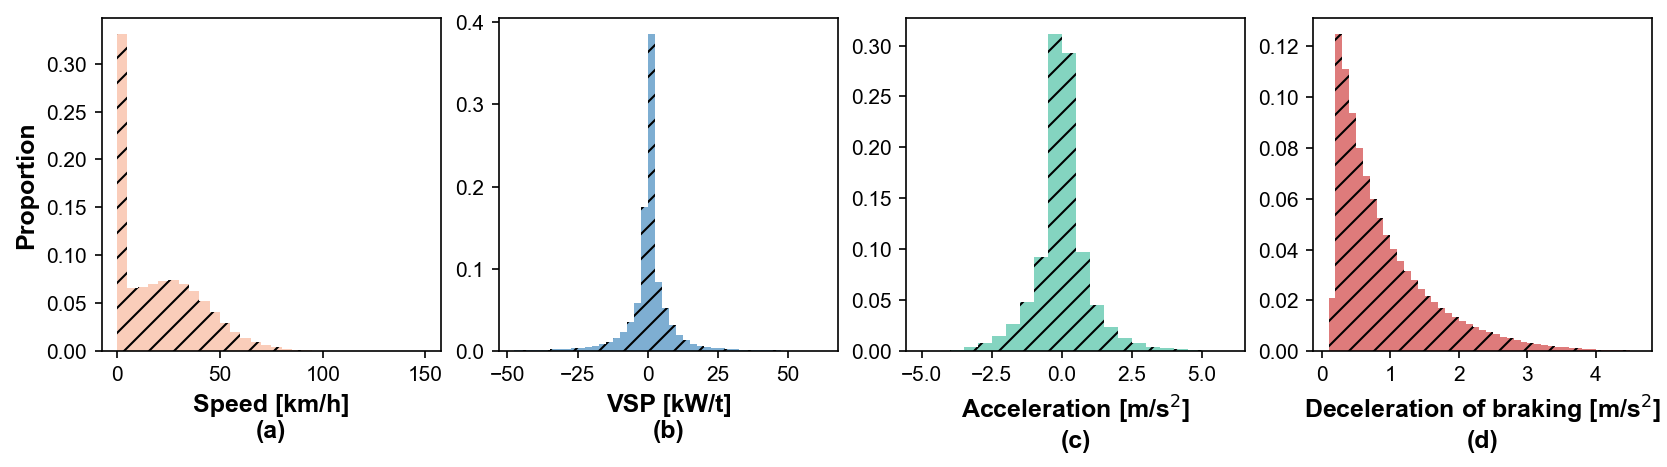

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(11,3), constrained_layout=True)

# speed
ax1.stairs(agg_overall['speedBinCount'].loc[0] / agg_overall['trajCount'].loc[0], SPEED_BIN, color=ORANGE, hatch='//', fill=True, alpha=0.6)
ax1.set_xlabel("Speed [km/h]\n(a)", fontdict=LABEL_FONT)
ax1.set_ylabel("Proportion", fontdict=LABEL_FONT)

# VSP
ax2.stairs(agg_overall['VSPBinCount'].loc[0] / agg_overall['trajCount'].loc[0], VSP_BIN, color=BLUE, hatch='//', fill=True, alpha=0.6)
ax2.set_xlabel("VSP [kW/t]\n(b)", fontdict=LABEL_FONT)

# acc
ax3.stairs(agg_overall['accBinCount'].loc[0] / agg_overall['trajCount'].loc[0], ACC_BIN, color=DEEPGREEN, hatch='//', fill=True, alpha=0.6)
ax3.set_xlabel("Acceleration [m/s$^2$]\n(c)", fontdict=LABEL_FONT)

# VSP
ax4.stairs(agg_overall['brakeDecelBinCount'].loc[0] / agg_overall['brakeCount'].loc[0], DECEL_BIN, color=RED, hatch='//', fill=True, alpha=0.6)
ax4.set_xlabel("Deceleration of braking [m/s$^2$]\n(d)", fontdict=LABEL_FONT)

plt.show()

The next step is to calculate the overall brake wear emission.

$$
ER_{avg} = \frac{1}{3}\times\sum_{m\in materials}\sum_{j\in bins} p(decel_j)\cdot ER^m(decel_j)
$$

In [5]:
# calculate the braking deceleration proportional distribution
agg_overall['brakeDecelBinFrac'] = agg_overall['brakeDecelBinCount'] / agg_overall['brakeCount']
brakeDecelBinFrac = agg_overall['brakeDecelBinCount'].iloc[0] / agg_overall['brakeCount'].iloc[0]

# ER calculator
from emission import BWETool
bwe = BWETool()
ER = bwe.ER

# calculate the average ER using the updated ER-decel curve and the MOVES curve
ER_avg = sum(ER.calER(DECEL_BIN[:-1], 'avg') * brakeDecelBinFrac)
ER_avg_MOVES = sum(ER.calER(DECEL_BIN[:-1], 'MOVES') * brakeDecelBinFrac)

ER_avg, ER_avg_MOVES

(2.2050418445692017, 4.767713733122556)

Average PM10 ER is `2.205 g/hr` using updated ER-decel curve and Chengdu decel distribution, and `4.768 g/hr` for MOVES curve.  
The average PM10 ER in MOVES report is `4.456 g/hr` (0.557 $\times$ 8).

## 2 OpMode Aggregation

In [6]:
with open("./data/agg/agg_OpMode.pkl", 'rb') as f:
    agg_OpMode = pickle.load(f)
agg_OpMode.head()

,trajCount,matchedCount,brakeCount,brakeDecelBinCount
0,352692562,352692562,352692562,"[0, 0, 0, 0, 0, 0, 0, 0, 2641573, 41249051, 36..."
1,798267033,798267033,50873939,"[11961873, 32081550, 6682769, 144994, 2749, 0,..."
11,505956974,505956974,473621687,"[4630226, 70554463, 81996575, 73582303, 630184..."
12,440613599,440613599,15451670,"[4716975, 10734695, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
13,198804569,198804569,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 2.1 Braking profile

The key step to calculate brake wear emissions is to assign ERs to OpModes properly. Two key elements for this task are:  
- braking fraction [%]
- braking deceleration distribution  
in each OpMode.

In [7]:
agg_OpMode['brakeFrac'] = agg_OpMode['brakeCount'] / agg_OpMode['trajCount']
agg_OpMode['brakeDecelBinFrac'] = agg_OpMode['brakeDecelBinCount'] / agg_OpMode['brakeCount']

The distribution of braking fraction is different from that in MOVES, especially in OpMode 21, 22, and 33.

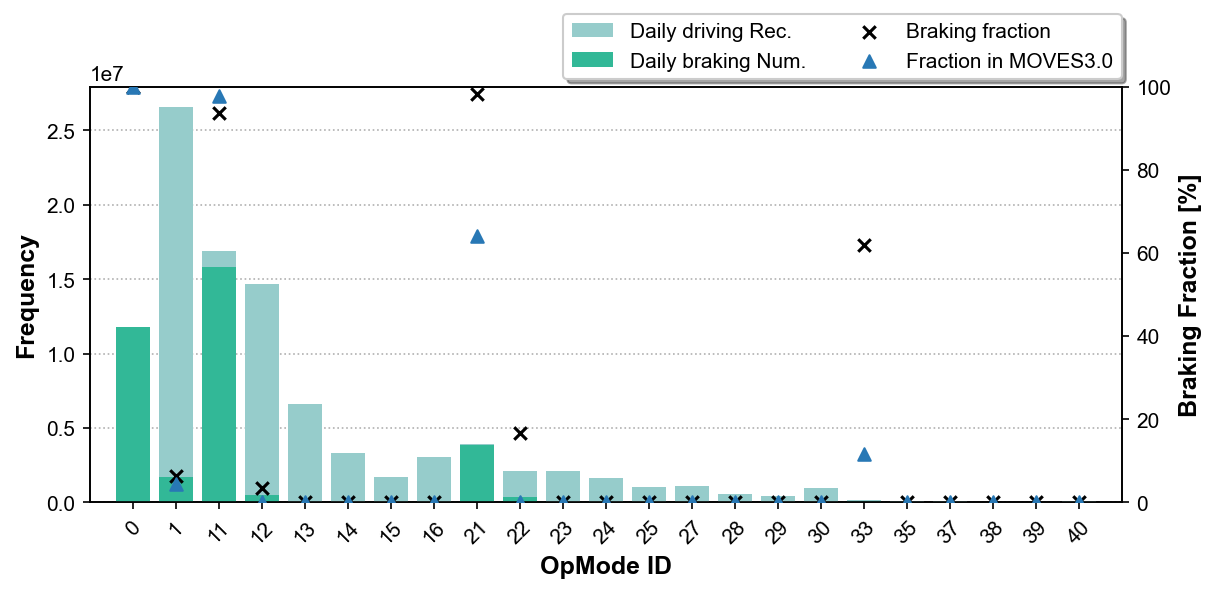

In [8]:
# plot OpMode info
fig, ax = plt.subplots(1,1, figsize=(8,3.5), constrained_layout=True)

# count-bar
modes = np.arange(0,agg_OpMode.shape[0])
ax.bar(modes, agg_OpMode['trajCount'] / 30, color=GREEN, label="Daily driving Rec." if CHN==False else "轨迹总数", zorder=100)
ax.bar(modes, agg_OpMode['brakeCount'] / 30, color=DEEPGREEN, label="Daily braking Num." if CHN==False else "刹车频次", zorder=100)

ax.set_xlim(-1,agg_OpMode.shape[0])
ax.set_xticks(modes)
ax.set_xticklabels(agg_OpMode.index, rotation=45)

# frac-scatter
ax_ = ax.twinx()
ax_.scatter(modes, agg_OpMode['brakeFrac']*100, color="k", marker="x", label="Braking fraction" if CHN==False else "刹车占比", zorder=200)
ax_.set_ylim(0, 100)

# MOVES
x_MOVES = modes
frac_MOVES = np.array((100, 4.37, 97.8, 0, 0, 0, 0, 0, 64.1, 0, 0, 0, 0, 0, 0, 0, 0, 11.5, 0, 0, 0, 0, 0))
ax_.scatter(x_MOVES, frac_MOVES, marker="^", color=BLUE, label="Fraction in MOVES3.0" if CHN==False else "刹车占比 (MOVES3)", zorder=200)

# labels
ax.set_xlabel("OpMode ID", fontdict=LABEL_FONT)
ax.set_ylabel("Frequency" if CHN==False else "频率", fontdict=LABEL_FONT)
ax_.set_ylabel("Braking Fraction [%]" if CHN==False else "刹车比例 [%]", fontdict=LABEL_FONT)

ax.grid(axis="y", linestyle=":", zorder=0)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.2), bbox_transform=ax.transAxes, ncol=2, shadow=True)
plt.show()

The majority driving records are contributed by OpMode 0, 1, 11, 12, 13, and 21 with a proportion of 81.5%.

In [9]:
agg_OpMode.loc[[0,1,11,12,13,21]]['trajCount'].sum() / agg_OpMode['trajCount'].sum()

0.8146537808500468

And the majority of braking samples are generated in OpMode 0, 11, and 21 with a proportion of 92.2%.

In [10]:
agg_OpMode.loc[[0,11,21]]['brakeCount'].sum() / agg_OpMode['brakeCount'].sum()

0.9218033450219072

### 2.2 Emission rate

#### *Initial Method*

The OpMode emission rate calculation method in MOVES is shown below:
$$
ER^i = p^i(brak.) \times ER_{avg}\quad\forall i\in OpModes
$$
> - $p(brak.)_{i}$ is the braking fraction in each OpMode.  

In [11]:
agg_OpMode['PM10 ER MOVES'] = agg_OpMode['brakeFrac'] * ER_avg

#### *Modified Method*

However, the braking deceleration in each OpMode is also worth consideration. Here we provide another calculation method considering decel distribution:
$$
ER^i = \frac{1}{3}\times\sum_{m\in materials}\sum_{j\in bins} p^i(decel_j) \times ER^m(decel_j)\quad\forall i\in OpModes
$$
> - $p^i(decel_j)$ is the proportion of each braking deceleration bin $j$ in OpMode $i$.
> - $ER^m(decel_j)$ is the corresponding emission rate of deceleration bin $i$ for material $m$ calculated from the ER-decel curve.

In [12]:
agg_OpMode['PM10 ER Avg'] = agg_OpMode['brakeDecelBinFrac'].apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'avg') * x))
agg_OpMode['PM10 ER LM'] = agg_OpMode['brakeDecelBinFrac'].apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'LM') * x))
agg_OpMode['PM10 ER SM'] = agg_OpMode['brakeDecelBinFrac'].apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'SM') * x))
agg_OpMode['PM10 ER NAO'] = agg_OpMode['brakeDecelBinFrac'].apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'NAO') * x))
agg_OpMode.fillna(0, inplace=True)

# generate the OpMode ERs
OpModeERs = agg_OpMode['PM10 ER Avg'].to_numpy()
# np.save("./data/agg/OpModeERs.npy", OpModeERs)

Using these two methods, we obtain the ER for each OpMode. It's obvious that OpMode 0 has the highest Avg.ER using both methods. But the ERs of OpMode 11, 21, 22 and 33 calculated by method A are higher than that of method B. This difference comes from the differential consideration of two methods.

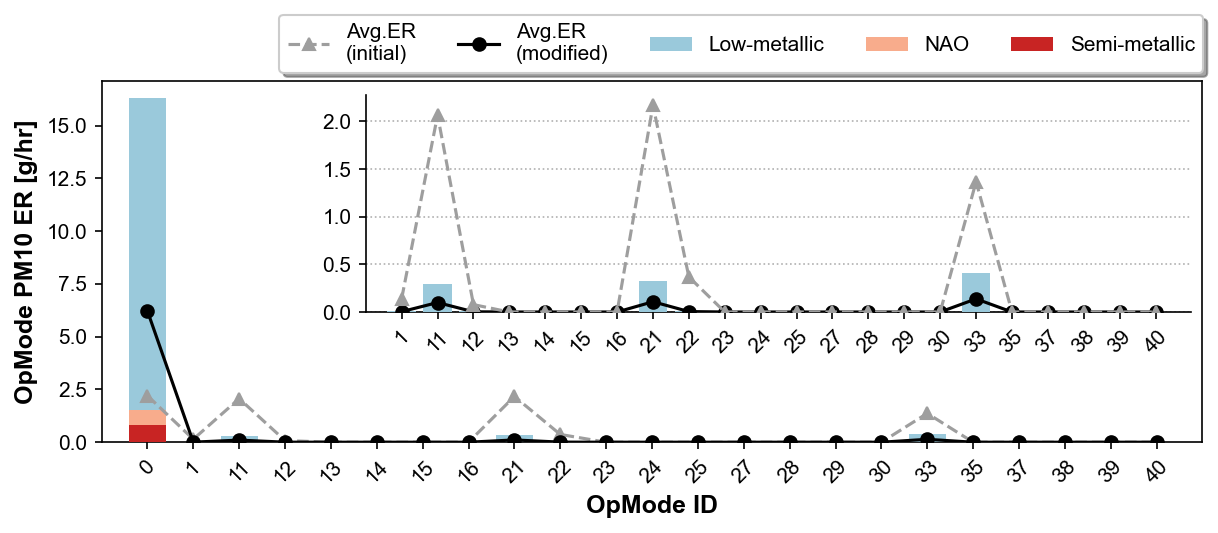

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# ER bar
modes = np.arange(0,agg_OpMode.shape[0])
ax.bar(modes, agg_OpMode['PM10 ER LM'], color=LIGHTBLUE, label="Low-metallic" if CHN==False else "低金属排放率", zorder=100)
ax.bar(modes, agg_OpMode['PM10 ER NAO'], color=ORANGE, label="NAO" if CHN==False else "NAO排放率", zorder=100)
ax.bar(modes, agg_OpMode['PM10 ER SM'], color=RED, label="Semi-metallic" if CHN==False else "半金属排放率", zorder=100)

ax.set_xlim(-1,agg_OpMode.shape[0])
ax.set_xticks(modes)
ax.set_xticklabels(agg_OpMode.index, rotation=45)

# plot
ax.plot(modes, agg_OpMode['PM10 ER MOVES'], color=GREY, marker="^", linestyle="--", label="Avg.ER\n(initial)" if CHN==False else "平均排放率\n(不考虑减速度分布)", zorder=200)
ax.plot(modes, agg_OpMode['PM10 ER Avg'], color="k", marker="o", label="Avg.ER\n(modified)" if CHN==False else "平均排放率\n(考虑减速度分布)", zorder=200)

# labels
ax.set_xlabel("OpMode ID", fontdict=LABEL_FONT)
ax.set_ylabel("OpMode PM10 ER [g/hr]" if CHN==False else "OpMode PM10排放率 [g/hr]", fontdict=LABEL_FONT)

# child axes
w, h = 0.75, 0.6
ax_ = ax.inset_axes([1-w-0.01, 1-h-0.04, w, h])
modes_ = np.arange(1,agg_OpMode.shape[0])
ax_.bar(modes_, agg_OpMode['PM10 ER LM'][1:], color=LIGHTBLUE, label="Low-metallic", zorder=200)
ax_.bar(modes_, agg_OpMode['PM10 ER NAO'][1:], color=ORANGE, label="NAO", zorder=200)
ax_.bar(modes_, agg_OpMode['PM10 ER SM'][1:], color=RED, label="Semi-metallic", zorder=200)
ax_.set_xlim(0,agg_OpMode.shape[0])
ax_.set_xticks(modes_)
ax_.set_xticklabels(agg_OpMode.index[1:], rotation=45)
ax_.plot(modes_, agg_OpMode['PM10 ER Avg'][1:], color="k", marker="o", label="Average", zorder=200)
ax_.plot(modes_, agg_OpMode['PM10 ER MOVES'][1:], color=GREY, marker="^", linestyle="--", label="Avg.ER*Brk.Frac.\n(used in MOVES)", zorder=200)
ax_.grid(axis="y", linestyle=":", zorder=0)
ax_.spines['top'].set_visible(False)
ax_.spines['right'].set_visible(False)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.21), bbox_transform=ax.transAxes, ncol=5, shadow=True)
plt.show()

The result shows that method A would underestimate the ER of OpMode with high deceleration of braking, such as OpMode 11, 21, and 33. In contrast, the ER of OpMode 0 is overestimated by method A.

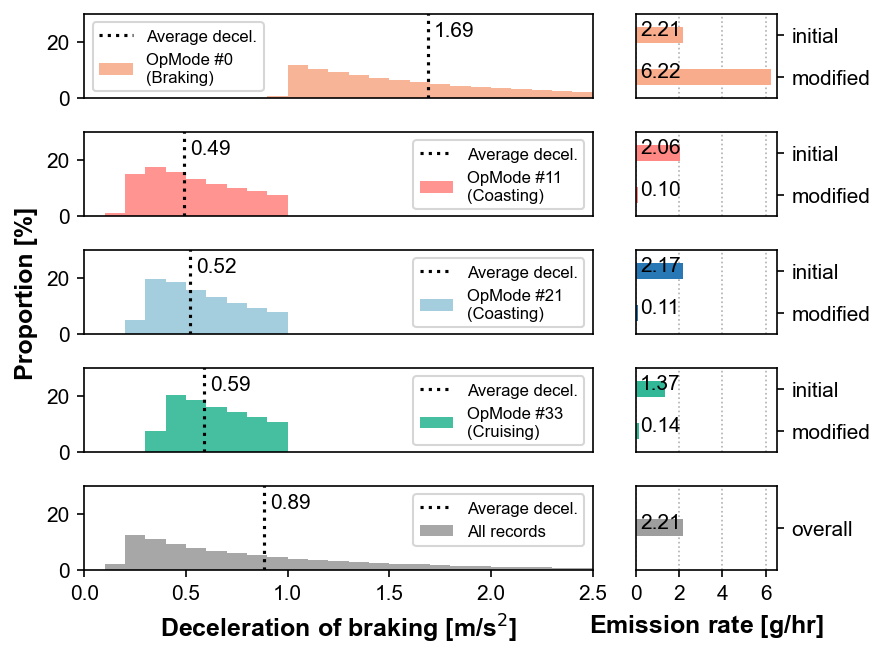

In [19]:
fig = plt.figure(figsize=(6,4.5))

ax1 = plt.subplot2grid((5,4), (0,0), colspan=3)  # 0-hist
ax2 = plt.subplot2grid((5,4), (1,0), colspan=3)  # 11-hist
ax3 = plt.subplot2grid((5,4), (2,0), colspan=3)  # 21-hist
ax4 = plt.subplot2grid((5,4), (3,0), colspan=3)  # 33-hist
ax5 = plt.subplot2grid((5,4), (4,0), colspan=3)  # all-hist

ax6 = plt.subplot2grid((5,4), (0,3))  # 0-bar
ax7 = plt.subplot2grid((5,4), (1,3))  # 11-bar
ax8 = plt.subplot2grid((5,4), (2,3))  # 21-bar
ax9 = plt.subplot2grid((5,4), (3,3))  # 33-bar
ax10 = plt.subplot2grid((5,4), (4,3))  # all-bar

# hist
decels = np.arange(0.1, 4.6, 0.1)

ax1.bar(decels, agg_OpMode.loc[0]['brakeDecelBinFrac']*100, width=0.1, alpha=0.9, zorder=2, align='edge', color=ORANGE, label="OpMode #0\n(Braking)" if CHN==False else "OpMode #0\n[刹车]")
avg_decel = sum(decels * agg_OpMode.loc[0]['brakeDecelBinFrac'])
ax1.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel." if CHN==False else "平均减速度")
ax1.text(avg_decel+0.03, 22, "%.2f" % avg_decel, zorder=2, color='k')
# ax1.text(0, 21.5 if CHN==False else 25, " #0\n(underestimated)" if CHN==False else "#0", fontweight='bold', fontsize=8)

ax2.bar(decels, agg_OpMode.loc[11]['brakeDecelBinFrac']*100, width=0.1, alpha=0.9, zorder=2, align='edge', color=PINK, label="OpMode #11\n(Coasting)" if CHN==False else "OpMode #11\n[滑行]")
avg_decel = sum(decels * agg_OpMode.loc[11]['brakeDecelBinFrac'])
ax2.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel." if CHN==False else "平均减速度")
ax2.text(avg_decel+0.03, 22, "%.2f" % avg_decel, zorder=2, color='k')
# ax2.text(0, 21.5 if CHN==False else 25, " #11\n(overestimated)" if CHN==False else "#11", fontweight='bold', fontsize=8)

ax3.bar(decels, agg_OpMode.loc[21]['brakeDecelBinFrac']*100, width=0.1, alpha=0.9, zorder=2, align='edge', color=LIGHTBLUE, label="OpMode #21\n(Coasting)" if CHN==False else "OpMode #21\n[滑行]")
avg_decel = sum(decels * agg_OpMode.loc[21]['brakeDecelBinFrac'])
ax3.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel." if CHN==False else "平均减速度")
ax3.text(avg_decel+0.03, 22, "%.2f" % avg_decel, zorder=2, color='k')
# ax3.text(0, 21.5 if CHN==False else 25, " #21\n(overestimated)" if CHN==False else "#21", fontweight='bold', fontsize=8)

ax4.bar(decels, agg_OpMode.loc[33]['brakeDecelBinFrac']*100, width=0.1, alpha=0.9, zorder=2, align='edge', color=DEEPGREEN, label="OpMode #33\n(Cruising)" if CHN==False else "OpMode #33\n[巡航]")
avg_decel = sum(decels * agg_OpMode.loc[33]['brakeDecelBinFrac'])
ax4.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel." if CHN==False else "平均减速度")
ax4.text(avg_decel+0.03, 22, "%.2f" % avg_decel, zorder=2, color='k')
# ax4.text(0, 21.5 if CHN==False else 25, " #33\n(overestimated)" if CHN==False else "#33", fontweight='bold', fontsize=8)

ax5.bar(decels, agg_overall['brakeDecelBinFrac'].iloc[0]*100, width=0.1, alpha=0.9, zorder=2, align='edge', color=GREY, label="All records" if CHN==False else "总体分布")
avg_decel = sum(decels * agg_overall['brakeDecelBinFrac'].iloc[0])
ax5.vlines(avg_decel, 0, 100, zorder=2, color='k', linestyle=":", label="Average decel." if CHN==False else "平均减速度")
ax5.text(avg_decel+0.03, 22, "%.2f" % avg_decel, zorder=2, color='k')
# ax5.text(0, 25, " All" if CHN==False else "总体", fontweight='bold', fontsize=8)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 2.5)
    ax.set_ylim(0, 30)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', colors='none')
    ax.legend(fontsize=8)
ax5.set_xlim(0, 2.5)
ax5.set_ylim(0, 30)
ax5.legend(fontsize=8)
# labels
ax3.set_ylabel("Proportion [%]" if CHN==False else "占比 [%]", fontdict=LABEL_FONT)
ax5.set_xlabel("Deceleration of braking [m/s$^2$]" if CHN==False else "减速度 [m/s$^2$]", fontdict=LABEL_FONT)


# ER comparison
ax6.barh(np.arange(0,2), agg_OpMode.loc[0][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=ORANGE)
ax6.text(0.2, 0.9, "%.2f"%agg_OpMode.loc[0]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax6.text(0.2, -0.1, "%.2f"%agg_OpMode.loc[0]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax7.barh(np.arange(0,2), agg_OpMode.loc[11][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=PINK)
ax7.text(0.2, 0.9, "%.2f"%agg_OpMode.loc[11]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax7.text(0.2, -0.1, "%.2f"%agg_OpMode.loc[11]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax8.barh(np.arange(0,2), agg_OpMode.loc[21][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=BLUE)
ax8.text(0.2, 0.9, "%.2f"%agg_OpMode.loc[21]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax8.text(0.2, -0.1, "%.2f"%agg_OpMode.loc[21]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax9.barh(np.arange(0,2), agg_OpMode.loc[33][['PM10 ER Avg', 'PM10 ER MOVES']], height=0.4, zorder=2, color=DEEPGREEN)
ax9.text(0.2, 0.9, "%.2f"%agg_OpMode.loc[33]['PM10 ER MOVES'], zorder=2, color='k', ha='left', va='bottom')
ax9.text(0.2, -0.1, "%.2f"%agg_OpMode.loc[33]['PM10 ER Avg'], zorder=2, color='k', ha='left',va='bottom')

ax10.barh(np.arange(0,1), ER_avg, height=0.2, zorder=2, color=GREY)
ax10.text(0.2, -0.05, "%.2f"%ER_avg, zorder=2, color='k', ha='left', va='bottom')

# set format
for ax in [ax6, ax7, ax8, ax9]:
    ax.set_xticks([0,2,4,6])
    ax.set_xticklabels([])
    ax.set_yticks([0,1])
    ax.set_yticklabels(['modified', 'initial'])
    ax.set_ylim(-0.5,1.5)
    ax.grid(axis="x", linestyle=":", zorder=0)
    ax.yaxis.tick_right()
    # ax.spines['bottom'].set_color('none')
    ax.tick_params(axis='x', colors='none')
ax10.set_xticks([0,2,4,6])
ax10.set_yticks([0])
ax10.set_yticklabels(['overall'])
ax10.set_ylim(-0.5,0.5)
ax10.grid(axis="x", linestyle=":", zorder=0)
ax10.yaxis.tick_right()
ax10.set_xlabel("Emission rate [g/hr]$^{}$", fontdict=LABEL_FONT)

for ax in [ax6, ax7, ax8, ax9, ax10]:
    ax.set_xlim(0, 6.5)
plt.tight_layout()
plt.show()
